# Locality Measure Pearson
We want to summarize, how local the covariance is, e.g. how big is the radius around a pixel so the accumulated covariance is below 95%? For this task, we define a covariance matrix $\Sigma$, with a constant variance on the diagonals, while the covariance decreases exponentially in all directions on a regular grid.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import ipywidgets as widgets
import utilities

In [2]:
def dist_covariance(Rho, idx, percent=0.95, precision=3, debug=False):
    n = np.int64(np.sqrt(Rho.shape[0]))
    rho_i = Rho[idx, :].reshape((n,n))
    
    pixel = np.array([
        idx % n,
        idx // n
    ])
    
    overallCovariance = rho_i.sum()
    condition = round(percent * overallCovariance, precision)
    
    if rho_i[pixel[1], pixel[0]] > percent * overallCovariance:
        return 0
    
    width = np.max(rho_i.shape) + 1
    for i in range(1, width):
        left = max(0, pixel[0]-i)
        right = min(rho_i.shape[0], pixel[0]+i+1)
        top = max(0, pixel[1]-i)
        bottom = min(rho_i.shape[1], pixel[1]+i+1)

        subset = rho_i[top:bottom, left:right]
        subset_sum = round(subset.sum(), precision)
        
        if debug:
            print(subset)
            mapping = np.zeros_like(Sigma_i)
            mapping[top:bottom, left:right] = 1
            print(subset_sum, condition)
            plt.figure()
            plt.suptitle('{:d} - {:f} > {:f}'.format(i, subset_sum, condition))
            plt.subplot(1,2,1)
            plt.imshow(mapping)
            ax = plt.gca()
            ax.set_xticks(np.arange(-.5, n, 1))
            ax.set_yticks(np.arange(-.5, n, 1))
            ax.set_xticklabels(np.arange(0, n+1, 1))
            ax.set_yticklabels(np.arange(0, n+1, 1))
            ax.grid(color='red', linestyle='-.', linewidth=1)

            plt.subplot(1,2,2)
            plt.imshow(subset)
            plt.colorbar()

            plt.show()
        
        if subset_sum > condition:
            # the subset contains now more that `percent` of the overall covariance,
            # thus the previus is below that thresshold
            return i - 1

        if right == rho_i.shape[0] and bottom == rho_i.shape[1] and left == 0 and top == 0:
            # maximum reached
            return i
    return width

def to_pearson(Sigma):
    variances = np.sqrt(np.diag(Sigma))
    
    # divide through the neigbouring variances and then through the own variance
    Sigma_hat = (Sigma / variances).T / variances
    
    return Sigma_hat

#Rho = to_pearson(Sigma_hat)
#p = np.array([5, 6])
#targetPixel = p[1] * gridDimensions[0] + p[0]
#dist_covariance(Rho, targetPixel, 0.52, debug=False)

#p = np.array([4, 6])
#targetPixel = p[1] * gridDimensions[0] + p[0]
#dist_covariance(Rho, targetPixel, 0.52, debug=False)

# Covariance with linear decay
We now consider a covariance $\Sigma$, which is homogene in its variance $\sigma^2$ and its covariance structure $\Sigma$ on a regular grid.

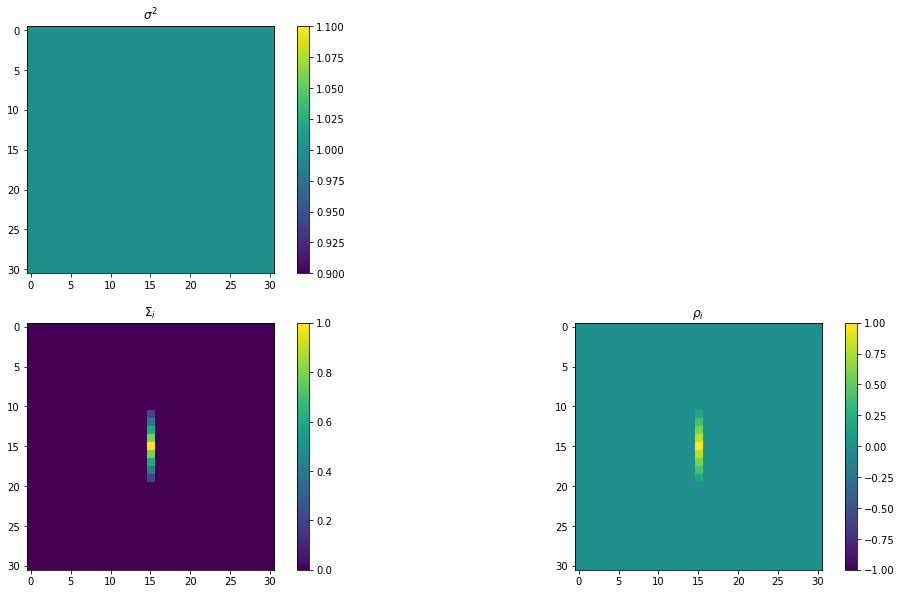

In [3]:
gridDimensions = np.array([31,31])
variance = np.ones(gridDimensions)

Sigma = utilities.build_covariance_y(variance, utilities.linear, 5)

# center pixel
p = np.array([gridDimensions[0]//2, gridDimensions[1]//2])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma))
sigma_x = variances[targetPixel]
# get only the correlated variances
covariances = Sigma_i.flatten()
rho_i = np.array([covariances[idx] / (sigma_x * sigma_y) for idx,sigma_y in enumerate(variances)]).reshape(gridDimensions)

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(rho_i, vmin=-1, vmax=1)
plt.title(r'$\rho_i$')
plt.colorbar()
plt.show()

# Inject some variations in the magnitude

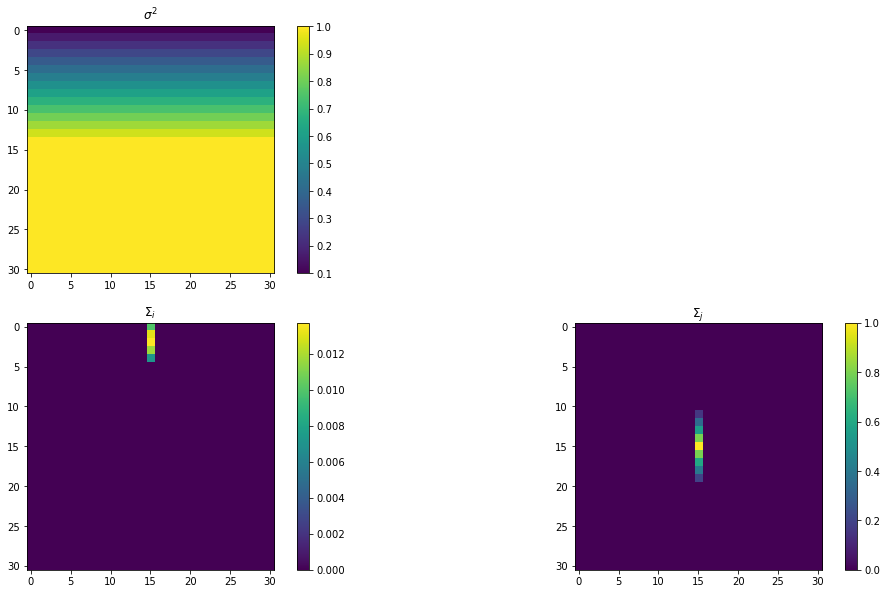

In [27]:
scaling = np.linspace(0.1, 1, gridDimensions[1]//2)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] *= scaling[y]
        Sigma_hat[:,idx] *= scaling[y]

p = np.array([gridDimensions[0]//2, 0])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

In [13]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [28]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

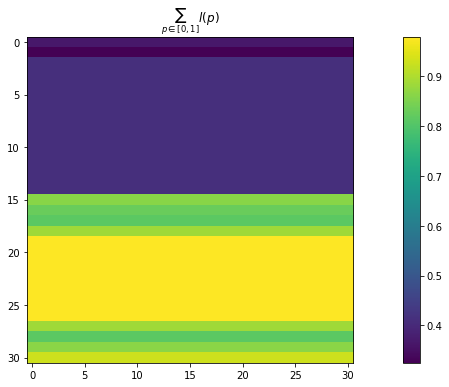

In [29]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Inject some variations in width of the structure

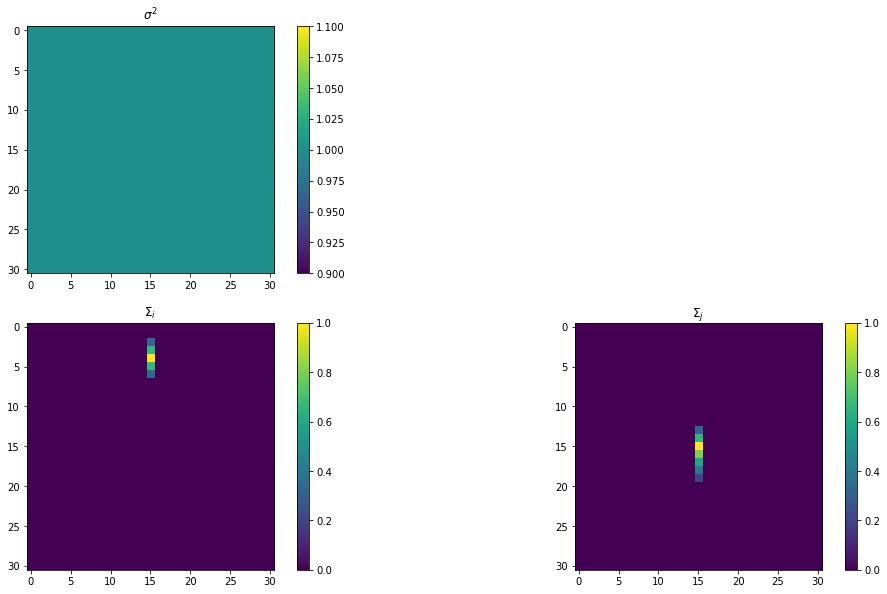

In [30]:
new_structure = utilities.build_covariance_y(variance, utilities.linear, 3)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] = new_structure[idx,:]
        Sigma_hat[:,idx] = new_structure[:,idx]

p = np.array([gridDimensions[0]//2, 4])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

In [31]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [32]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

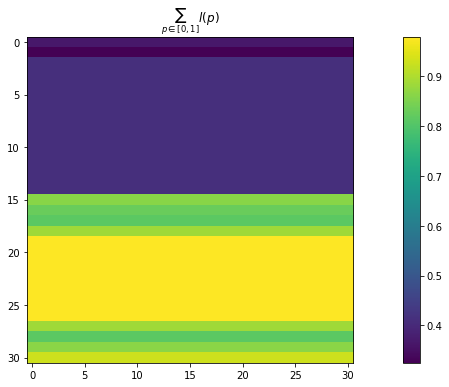

In [33]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Inject some variations in the dirstribution of the structure

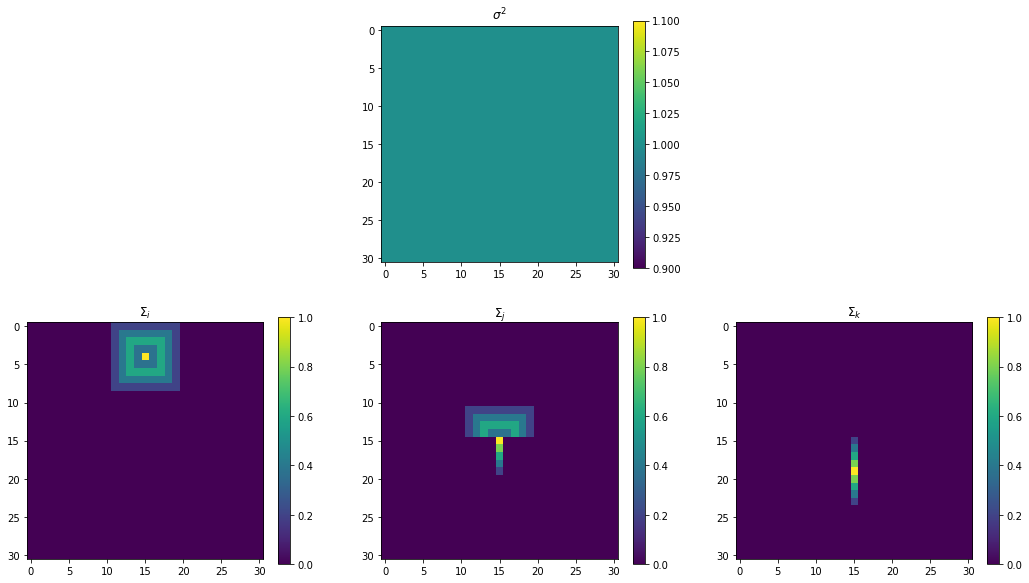

In [36]:
new_structure = utilities.build_covariance_matrix(variance, utilities.linear, 5)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] = new_structure[idx,:]
        Sigma_hat[:,idx] = new_structure[:,idx]

p = np.array([gridDimensions[0]//2, 4])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 19])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_k = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,3,2)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(Sigma_k)
plt.title(r'$\Sigma_k$')
plt.colorbar()
plt.show()

In [37]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [38]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

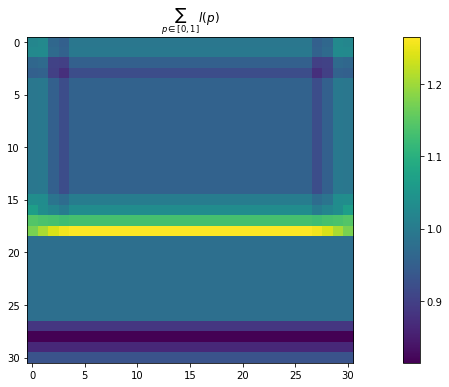

In [42]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Using experimental data

In [43]:
Sigma_radon = np.load('../../Data/iradon/Sigma_w10_p5_cosine.npy')
Rho_radon = to_pearson(Sigma_radon)
gridDimensions = np.array([64,64])

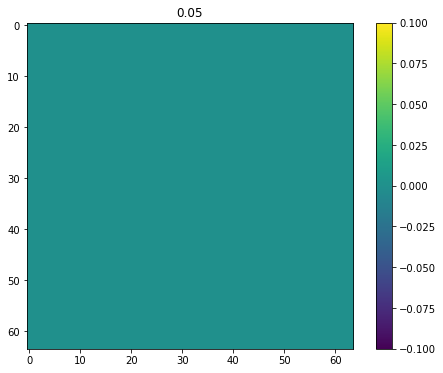

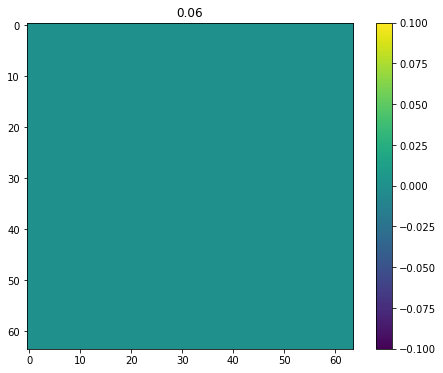

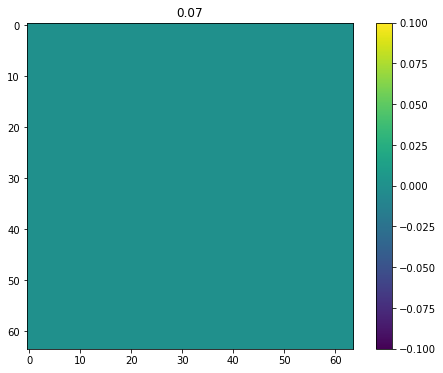

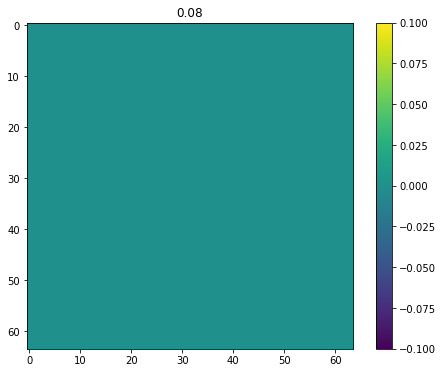

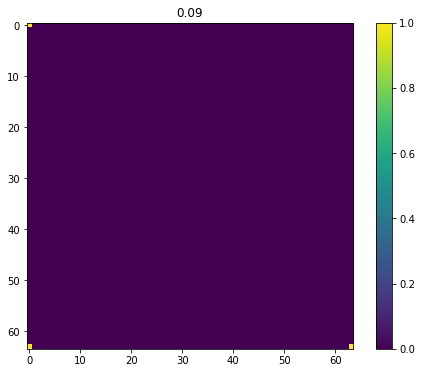

In [20]:
for percent in np.arange(0.05, 0.1, 0.01):
    localityMap = np.array([dist_covariance(Rho_radon, p, percent) for p in range(Sigma_radon.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('{:g}'.format(percent))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

# Statistical methods
Now let $O = \{l(p_i), 1\% \leq p_i \leq 25\%\}$ be a set of localities for different percentage cuts $1\% \leq p_i \leq 25\%$.

In [44]:
num = 25
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho_radon, p, percent) for p in range(Sigma_radon.shape[0])]).reshape(gridDimensions)

# Sum

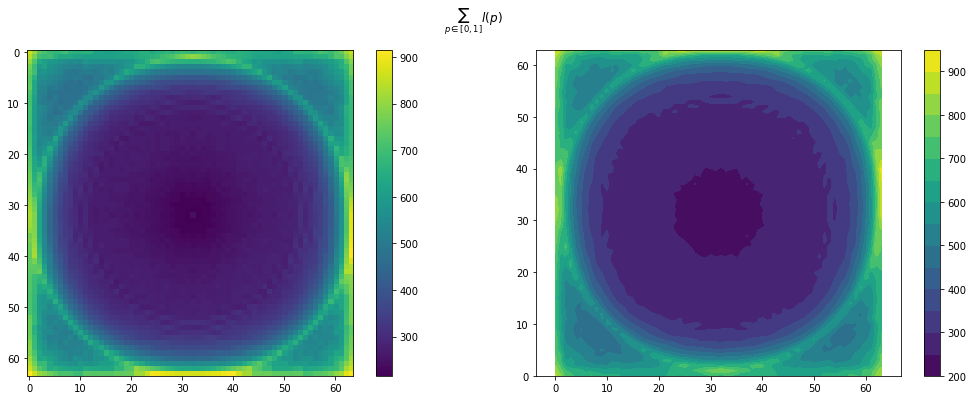

In [68]:
summing = np.sum(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$\sum_{p \in [0,1]} l(p)$')
plt.subplot(1,2,1)
plt.imshow(summing)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(summing, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()

# Mean

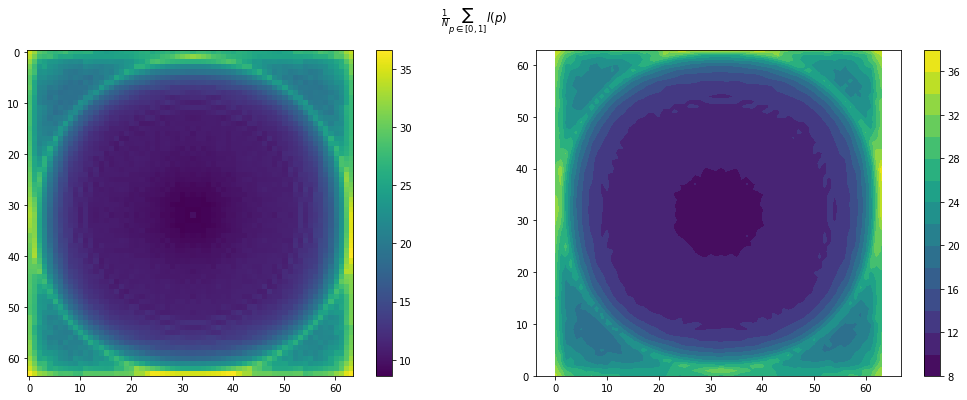

In [57]:
meaning = np.mean(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$\frac{1}{N}\sum_{p \in [0,1]} l(p)$')
plt.subplot(1,2,1)
plt.imshow(meaning)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(meaning, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()

# Variance

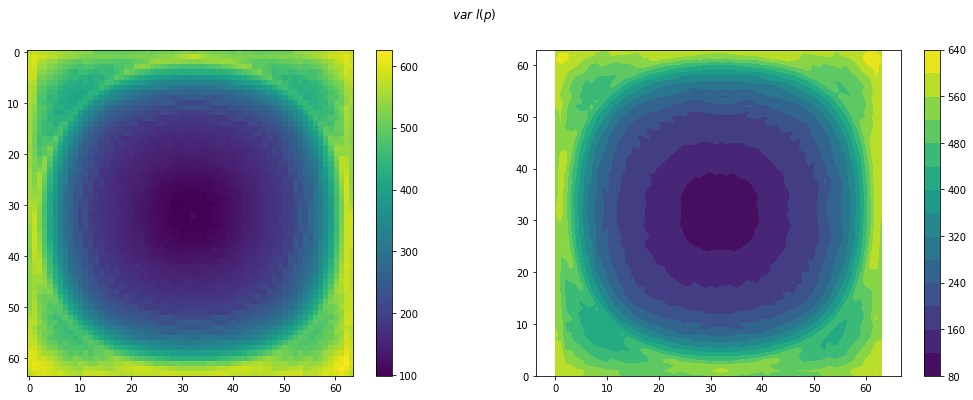

In [59]:
variing = np.var(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$var ~ l(p)$')
plt.subplot(1,2,1)
plt.imshow(variing)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(variing, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()

# Standard deviation

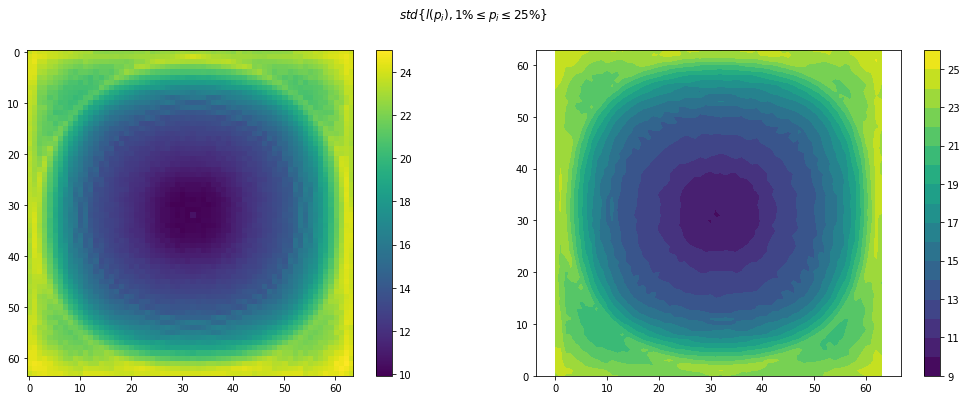

In [60]:
stding = np.std(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$std \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.subplot(1,2,1)
plt.imshow(stding)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(stding, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()

# Range

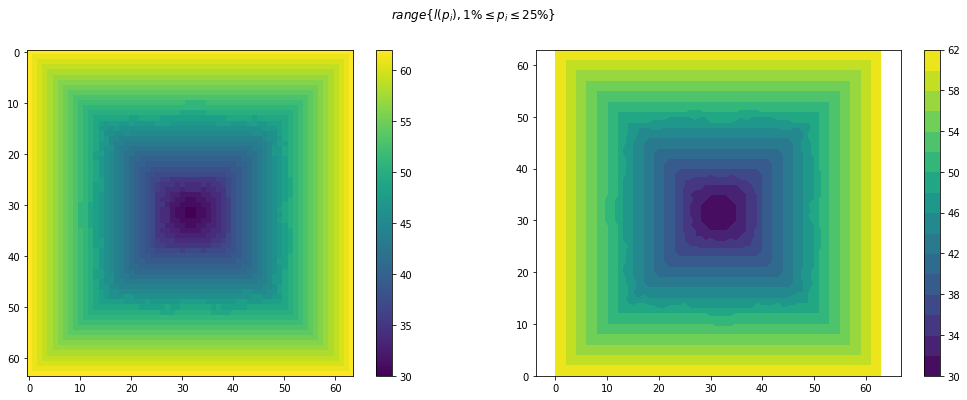

In [61]:
ranging = np.max(overview, axis=2) - np.min(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$range \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.subplot(1,2,1)
plt.imshow(ranging)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(ranging, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()

# Median

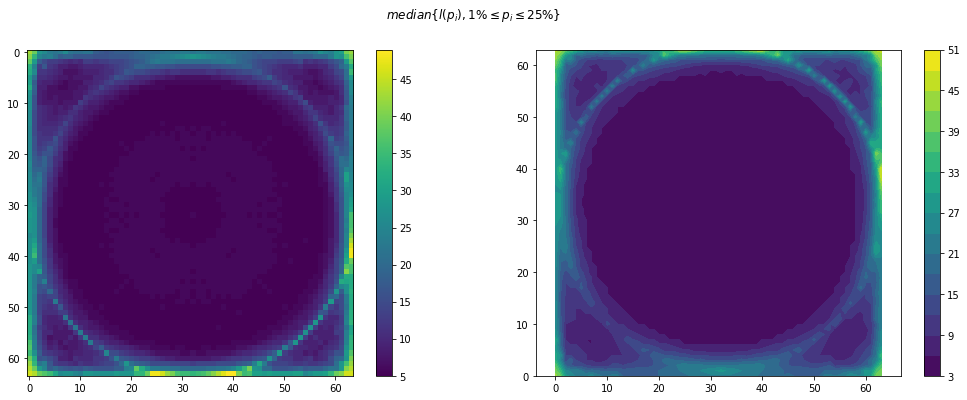

In [62]:
mediing = np.median(overview, axis=2)

plt.figure(figsize=(18,6))
plt.suptitle(r'$median \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.subplot(1,2,1)
plt.imshow(mediing)
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(mediing, levels=15)
plt.axis('equal')
plt.colorbar()
plt.show()